In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/week8/trum_tweet_sentiment_analysis.csv')
df.head()


,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0


In [4]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+|#', '', text)  # Remove mentions/hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)  # Join back into a string

In [5]:
# Apply preprocessing to the tweet text
df['cleaned_text'] = df['text'].apply(preprocess_text)

# View the results
df[['text', 'Sentiment', 'cleaned_text']].head()


,text,Sentiment,cleaned_text
0,RT @JohnLeguizamo: #trump not draining swamp b...,0,rt trump draining swamp taxpayer dollar trip a...
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0,icymi hacker rig fm radio station play antitru...
2,Trump protests: LGBTQ rally in New York https:...,1,trump protest lgbtq rally new york bbcworld via
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0,hi im pier morgan david beckham awful donald t...
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0,rt tech firm suing buzzfeed publishing unverif...


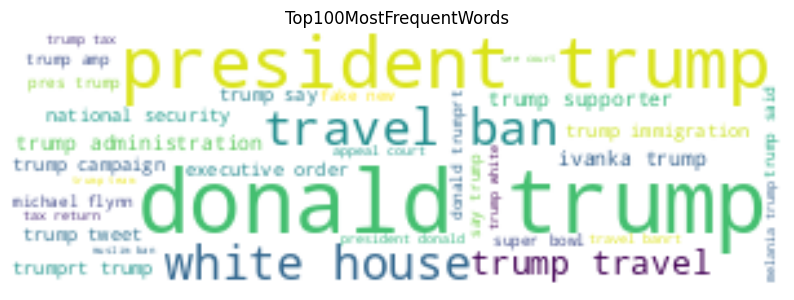

In [6]:
#---Visualization:WordCloud(Top100Words)--
all_words=''.join(df['cleaned_text'])
 #GenerateWordCloudwithonlytop100words
wordcloud=WordCloud(
 width=300,
 height=100,
 background_color='white',
 max_words=100#Limittotop100words
 ).generate(all_words)
 #Plotsettings
plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Top100MostFrequentWords')
plt.show()

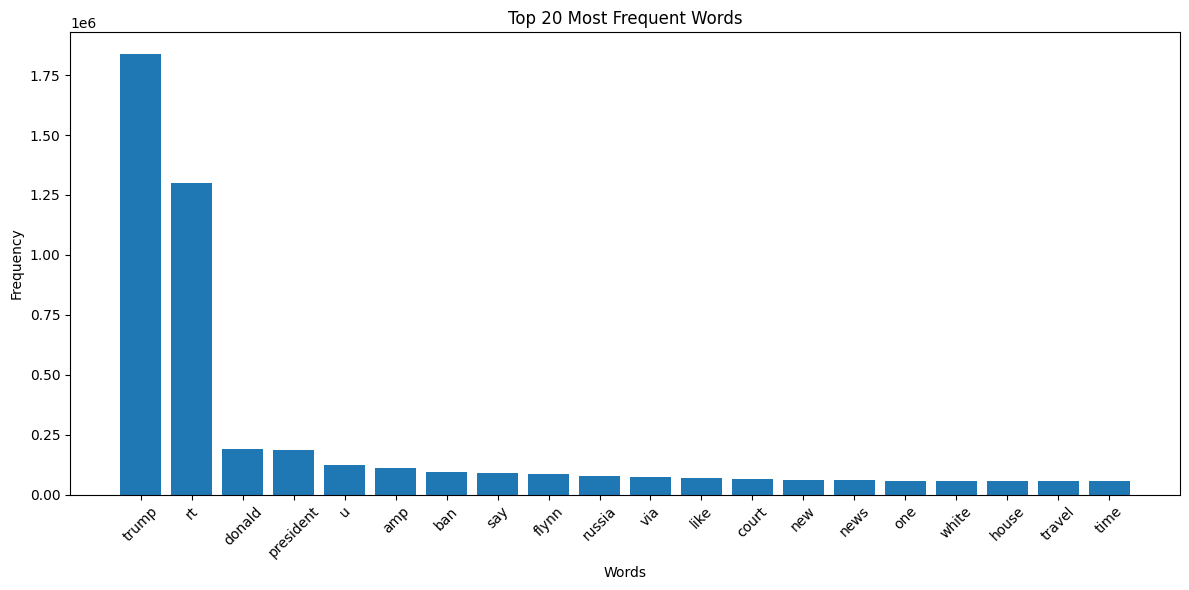

In [7]:
from collections import Counter

# Tokenize all cleaned text
all_words = ' '.join(df['cleaned_text']).split()
word_freq = Counter(all_words)

# Display top 20 words
common_words = word_freq.most_common(20)

# Plot
words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


**Tokenization & Padding**

 • Split the dataset into 80% training and 20% testing using train

 • Use Keras Tokenizer to convert text into sequences.
 test split.

• Apply padding to ensure uniform sequence lengths (use percentile-based padding)

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [9]:
# 1. Extract features and labels
X = df['cleaned_text'].values
y = df['Sentiment'].values  # make sure this is binary (0/1)

# 2. Split into train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Tokenize the text
vocab_size = 10000  # or any reasonable number
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 4. Apply percentile-based padding
# Compute the 95th percentile of training sequence lengths
train_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(train_lengths, 95))  # e.g., 95% percentile

# Pad sequences to max_len
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("Vocabulary size:", len(tokenizer.word_index))
print("Max sequence length:", max_len)
print("X_train shape:", X_train_pad.shape)
print("X_test shape:", X_test_pad.shape)


Vocabulary size: 141191
Max sequence length: 16
X_train shape: (1480098, 16)
X_test shape: (370025, 16)


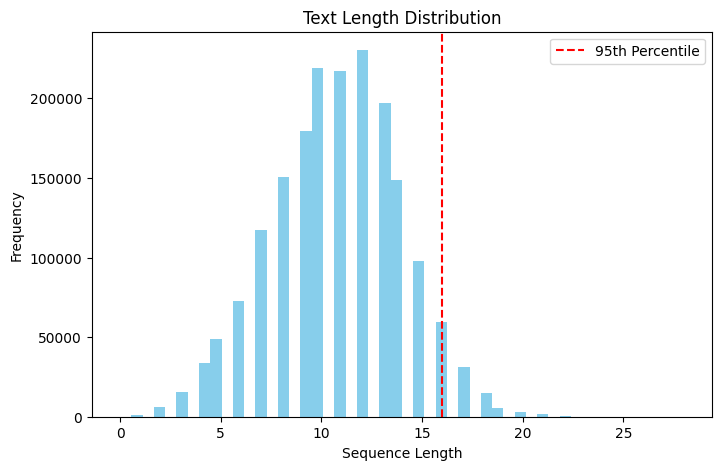

In [10]:
 X_seq = tokenizer.texts_to_sequences(df['cleaned_text'])
 seq_lengths = [len(seq) for seq in X_seq]
 plt.figure(figsize=(8, 5))
 plt.hist(seq_lengths, bins=50, color='skyblue')
 plt.title('Text Length Distribution')
 plt.xlabel('Sequence Length')
 plt.ylabel('Frequency')
 plt.axvline(np.percentile(seq_lengths, 95), color='red', linestyle='dashed', label='95th Percentile'
 )
 plt.legend()
 plt.show()

**3.Model Building**

Implement two models:

 Simple RNN

 LSTM

 Each model should include:

• Embedding Layer (inputdim=vocab size, output dim=128)

 • Recurrent Layer (SimpleRNN or LSTM with 64 units)
 dim=vocab
 size, output
 dim=128)

 • Dense Layer (sigmoid activation for binary classification)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense

# Common model parameters
vocab_size = 10000        # Size of the vocabulary
embedding_dim = 128       # Dimension of embedding vectors
max_length = 100          # Max sequence length (input length)
rnn_units = 64            # Units in RNN/LSTM

# --- SimpleRNN Model ---
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(units=rnn_units, return_sequences=False),
    Dense(1, activation='softmax')
])


# Build to show actual shapes and parameter counts
rnn_model.build(input_shape=(None, max_length))

print("\n--- SimpleRNN Model (Built) ---")
rnn_model.summary()

# --- LSTM Model ---
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(units=rnn_units, return_sequences=False),
    Dense(1, activation='softmax')
])


# Build to show actual shapes and parameter counts
lstm_model.build(input_shape=(None, max_length))

print("\n--- LSTM Model (Built) ---")
lstm_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



--- SimpleRNN Model (Built) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,292,417 (4.93 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)


--- LSTM Model (Built) ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Compile both models
for model in [rnn_model, lstm_model]:
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

# Train RNN model
print("\n--- Training SimpleRNN Model ---")
history_rnn = rnn_model.fit(
    X_train_pad, y_train,
    epochs=5,
    validation_split=0.2,
    callbacks=[early_stop],
    batch_size=128
)

# Train LSTM model
print("\n--- Training LSTM Model ---")
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    epochs=5,
    validation_split=0.2,
    callbacks=[early_stop],
    batch_size=128
)




--- Training SimpleRNN Model ---
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


9251/9251 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.3277 - loss: 0.2109 - val_accuracy: 0.3266 - val_loss: 0.1185
Epoch 2/5
9251/9251 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - accuracy: 0.3277 - loss: 0.0958 - val_accuracy: 0.3266 - val_loss: 0.1037
Epoch 3/5
9251/9251 ━━━━━━━━━━━━━━━━━━━━ 77s 4ms/step - accuracy: 0.3276 - loss: 0.0737 - val_accuracy: 0.3266 - val_loss: 0.1063
Epoch 4/5
9251/9251 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.3279 - loss: 0.0599 - val_accuracy: 0.3266 - val_loss: 0.1039

--- Training LSTM Model ---
Epoch 1/5
9251/9251 ━━━━━━━━━━━━━━━━━━━━ 68s 7ms/step - accuracy: 0.3273 - loss: 0.2062 - val_accuracy: 0.3266 - val_loss: 0.1112
Epoch 2/5
9251/9251 ━━━━━━━━━━━━━━━━━━━━ 64s 7ms/step - accuracy: 0.3272 - loss: 0.0971 - val_accuracy: 0.3266 - val_loss: 0.0956
Epoch 3/5
9251/9251 ━━━━━━━━━━━━━━━━━━━━ 79s 7ms/step - accuracy: 0.3278 - loss: 0.0743 - val_accuracy: 0.3266 - val_loss: 0.0884
Epoch 4/5
9251/9251 ━━━━━━━━━━━━━━━━━━━━ 61s 7ms/step - accuracy: 0.327

In [13]:
# --- Evaluation Function ---
def evaluate_model(model, X_test, y_test, name="Model"):
    print(f"\n--- Evaluation for {name} ---")

    # Evaluate accuracy
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Accuracy: {acc:.4f}")

    # Predict classes
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    # Confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Evaluate both models
evaluate_model(rnn_model, X_test_pad, y_test, "SimpleRNN")
evaluate_model(lstm_model, X_test_pad, y_test, "LSTM")


--- Evaluation for SimpleRNN ---
Accuracy: 0.3283


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


11564/11564 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step

Confusion Matrix:
[[     0 248563]
 [     0 121462]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    248563
           1       0.33      1.00      0.49    121462

    accuracy                           0.33    370025
   macro avg       0.16      0.50      0.25    370025
weighted avg       0.11      0.33      0.16    370025


--- Evaluation for LSTM ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.3283
   83/11564 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


11564/11564 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Confusion Matrix:
[[     0 248563]
 [     0 121462]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    248563
           1       0.33      1.00      0.49    121462

    accuracy                           0.33    370025
   macro avg       0.16      0.50      0.25    370025
weighted avg       0.11      0.33      0.16    370025



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Visualization**

 • Plot training vs. validation loss & accuracy over epochs.

 • Compare RNN vs. LSTM performance.

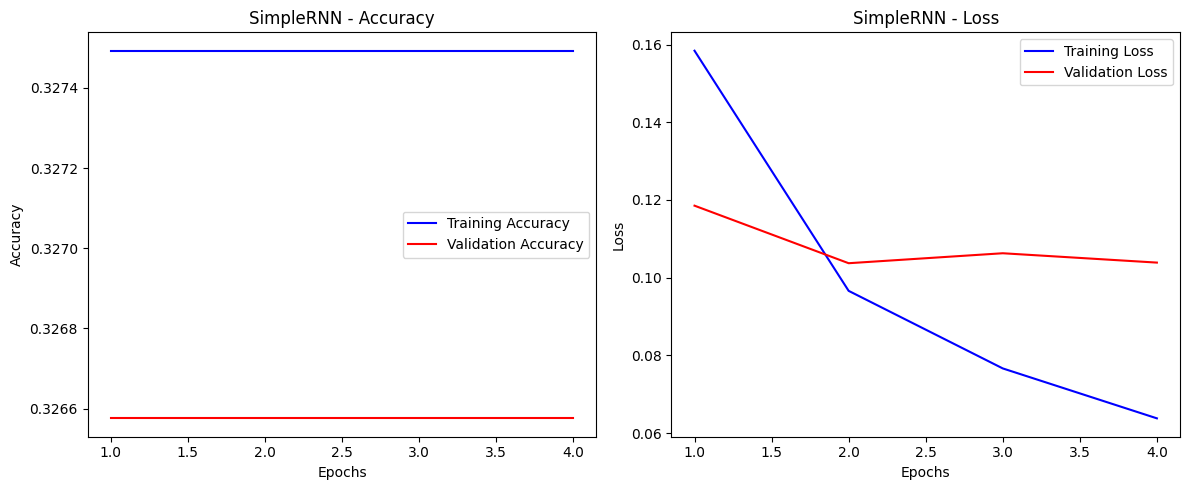

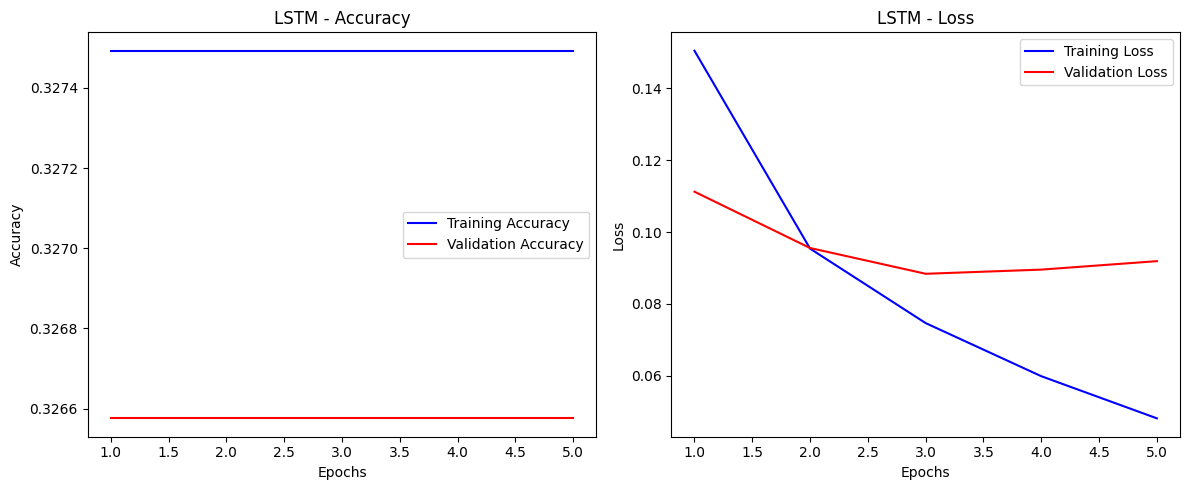

In [14]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting both models
plot_history(history_rnn, "SimpleRNN")
plot_history(history_lstm, "LSTM")


In [18]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00


In [26]:
!pip install gradio nltk tensorflow
!python twitter_sentiment_app.py


python3: can't open file '/content/twitter_sentiment_app.py': [Errno 2] No such file or directory


In [29]:
import gradio as gr
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Preprocessing setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
MAX_LEN = 50  # Replace this with the same value used during training

def preprocess_input(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

def predict_sentiment(tweet):
    cleaned = preprocess_input(tweet)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
    prediction = lstm_model.predict(padded)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    return f"{sentiment} ({prediction:.2f})"

interface = gr.Interface(fn=predict_sentiment,
                         inputs="text",
                         outputs="text",
                         title="Twitter Sentiment Predictor",
                         description="Enter a tweet to classify it as positive or negative using LSTM.")

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e810d202a0840933f3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
